# Task3 特征工程

### 导入包并读取数据

In [1]:
print("hello")

hello


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [3]:
data_train = pd.read_csv('data/train.csv')
data_test_a = pd.read_csv('data/testA.csv')

In [4]:
# numerical_fea 是一个列表，包含 data_train 中所有非 object 类型的列名（即数值型列）
numerical_fea  = list(data_train.select_dtypes(exclude=['object']).columns)
# 使用 filter 函数和 lambda 表达式来筛选出那些不在 numerical_fea 列表中的列名。
category_fea = list(filter(lambda x: x not in numerical_fea, list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

查看缺失值情况

In [5]:
#查看缺失值情况
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

In [6]:
# 按照中位数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna( data_train[numerical_fea].median() )
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna( data_test_a[numerical_fea].median() )

#按照众数填充类别型特征
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())


In [7]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

In [8]:
#查看类别特征
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

### 时间格式处理

In [9]:
#转化成时间格式
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [10]:
data_train['issueDateDT'].value_counts(dropna=False)

issueDateDT
3196    29066
3044    25525
2952    24496
3105    23245
2679    21461
        ...  
61         23
30         21
458        19
92          7
0           1
Name: count, Length: 139, dtype: int64

In [11]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

employmentLength
1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: count, dtype: int64

In [12]:
from utils_jessie import employmentLength_to_int

In [13]:
for data in [data_train, data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [14]:
data['employmentLength'].value_counts(dropna=False).sort_index()

employmentLength
0.0     15989
1.0     13182
2.0     18207
3.0     16011
4.0     11833
5.0     12543
6.0      9328
7.0      8823
8.0      8976
9.0      7594
10.0    65772
NaN     11742
Name: count, dtype: int64

### 对earliesCreditLine进行预处理

In [15]:
data_train['earliesCreditLine'].sample(5)

496638    Jan-1990
430737    Feb-1994
426042    Nov-2000
248817    Sep-2003
615991    May-2005
Name: earliesCreditLine, dtype: object

In [16]:
for data in [data_train,data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

### 类别特征处理

In [17]:
# 部分类别特征
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 79282
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 889
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 12058
policyCode 类型数： 1


In [18]:
# 像等级这种类别特征，是有优先级的可以labelencode或者自映射

for data in [data_train, data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [19]:
# 类型数在2之上，又不是高维稀疏的,且纯分类特征
for data in [data_train,data_test_a]:
    data = pd.get_dummies(data,columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'],drop_first=True)

#### 异常值处理

In [20]:
from utils_jessie import find_outliers_by_3segama

In [21]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

id_outliers
正常值    800000
Name: count, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
loanAmnt_outliers
正常值    800000
Name: count, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
term_outliers
正常值    800000
Name: count, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
interestRate_outliers
正常值    794259
异常值      5741
Name: count, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
installment_outliers
正常值    792046
异常值      7954
Name: count, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
employmentTitle_outliers
正常值    800000
Name: count, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
homeOwnership_outliers
正常值    799701
异常值       299
Name: count, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype

例如可以看到异常值在两个变量上的分布几乎复合整体的分布，如果异常值都属于为1的用户数据里面代表什么呢？


In [22]:
#删除异常值
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliers']=='正常值']
    # 在每次过滤操作后，调用 reset_index(drop=True) 方法重新设置 DataFrame 的索引，并丢弃旧的索引
    data_train = data_train.reset_index(drop=True)

## 数据分箱

In [23]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

In [24]:
# 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

In [25]:
# 分位数分箱
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)

## 特征交互

In [26]:
for col in ['grade', 'subGrade']:
    # 对于每一个列名（'grade' 和 'subGrade'）

    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    # 1. 使用 groupby 按照当前列（'grade' 或 'subGrade'）进行分组。
    # 2. 计算每组中 'isDefault' 列的平均值。
    # 3. 使用 reset_index() 将分组结果转换为 DataFrame。
    # 4. 重命名聚合后的列名为 col + '_target_mean' （例如 'grade_target_mean' 或 'subGrade_target_mean'）。

    temp_dict.index = temp_dict[col].values
    # 将临时 DataFrame 的索引设置为当前列的值（即 'grade' 或 'subGrade' 的值）。

    temp_dict = temp_dict[col + '_target_mean'].to_dict()
    # 将包含目标均值的 Series 转换为字典，键是类别值，值是对应的 'isDefault' 平均值。

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    # 使用 map 函数将训练集中的 'grade' 或 'subGrade' 列映射到其对应的 'isDefault' 平均值，并创建新列存储结果。

    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)
    # 同样地，对测试集进行相同的映射操作，创建新列存储结果。

In [27]:
# 对训练集和测试集进行循环处理
for df in [data_train, data_test_a]:
    # 对每个指定的列名 'n0', 'n1', ..., 'n14' 进行循环
    for item in ['n0','n1','n2','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        # 计算 'grade' 列相对于 'item' 列分组后 'grade' 的均值，并创建新列存储结果
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')

        # 计算 'grade' 列相对于 'item' 列分组后 'grade' 的标准差，并创建新列存储结果
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

### 特征编码

labelEncode 直接放入树模型中


In [28]:
# label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换

# 对指定的列进行标签编码
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    # 初始化 LabelEncoder
    le = LabelEncoder()
    # 合并训练集和测试集中的该列数据，并转换为字符串类型
    combined_data = list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values)
    # 拟合 LabelEncoder
    le.fit(combined_data)
    # 对训练集和测试集中的该列进行转换
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding 完成')

100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

Label Encoding 完成


#### 逻辑回归等模型要单独增加的特征工程

- 对特征做**归一化**，去除相关性高的特征
- 归一化目的是让训练过程更好更快的收敛，避免特征大吃小的问题
- 去除相关性是增加模型的可解释性，加快预测过程。

> 1. 除以最大值：所有特征除以各自的范围最大值，使得特征值范围都在0~1之间。于是$0.15 \leq \frac {x_1}{2000} \leq 1$、 $0 \leq \frac{x_2}{5} \leq 1$
> 2. 均值归一化(Mean normalization)：使得特征值范围大致为-1~1。假设$x_1$ 的平均值为 $\mu_1 =600、x_2的平均值为 \mu_2 = 2.3 \ ，于是-0.18 \leq \frac{x_1-\mu_1}{2000-300} \leq 0.82、-0.46 \leq \frac{x_2 - \mu_2}{5-0} \leq 0.54$
> 3. Z-score归一化(Z-score normalization)【推荐】：使得特征值服从标准正态分布。假设$x_1$的平均值和标准差分别为$\mu_1 = 600，\sigma_1 = 450 ，x_2 $ 的平均值和标准差分别为$\mu_2 = 2.3，\sigma_2 = 1.4 $ 于是  $-0.67 \leq \frac{x_1 - \mu_1}{\sigma_1} \leq 3.1  $  ,  $-1.6 \leq \frac{x_2- \mu_2}{\sigma_2 } \leq 1.9 $



## 特征选择

In [29]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# #参数k为选择的特征个数
#
# SelectKBest(chi2, k=5).fit_transform(data_train,data_train['isDefault'])

本数据集中我们删除非入模特征后，并对缺失值填充，然后用计算协方差的方式看一下特征间相关性，然后进行模型训练

```
# 删除不需要的数据
for data in [data_train, data_test_a]:
    data.drop(['issueDate'], axis=1,inplace=True)
```

In [30]:
# 删除不需要的数据
for data in [data_train, data_test_a]:
    data.drop(['issueDate'], axis=1,inplace=True)

In [31]:
for data in [data_train, data_test_a]:
    data.drop(['id'], axis=1,inplace=True)

In [32]:
"纵向用缺失值上面的值替换缺失值"
data_train = data_train.fillna(method='ffill')

In [33]:
x_train = data_train
#计算协方差
data_corr = x_train.corrwith(data_train.isDefault) #计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

ValueError: could not convert string to float: '正常值'

In [35]:
# 当然也可以直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

KeyError: "['id'] not in index"

In [36]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test_a[features]
y_train = data_train['isDefault']

In [37]:
x_train.columns

Index(['loanAmnt', 'term', 'interestRate', 'installment', 'grade', 'subGrade',
       'employmentTitle', 'employmentLength', 'homeOwnership', 'annualIncome',
       'verificationStatus', 'purpose', 'postCode', 'regionCode', 'dti',
       'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc',
       'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueDateDT',
       'grade_target_mean', 'subGrade_target_mean', 'grade_to_mean_n0',
       'grade_to_std_n0', 'grade_to_mean_n1', 'grade_to_std_n1',
       'grade_to_mean_n2', 'grade_to_std_n2', 'grade_to_mean_n4',
       'grade_to_std_n4', 'grade_to_mean_n5', 'grade_to_std_n5',
       'grade_to_mean_n6', 'grade_to_std_n6', 'grade_to_mean_n7',
       'grade_to_std_n7', 'grade_to_mean_n8', 'grade_to_std_n8',
      

In [113]:
from lightgbm import log_evaluation,early_stopping

In [118]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    feature_importance_df = pd.DataFrame()

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i + 1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], \
                                     train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs': 24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix],
                              callbacks=[log_evaluation(200),early_stopping(200)])
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)

            # 获取特征重要性
            fold_importance_df = pd.DataFrame()
            fold_importance_df["Feature"] = trn_x.columns
            fold_importance_df["importance"] = model.feature_importance(importance_type='gain')
            fold_importance_df["fold"] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])

        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x, label=trn_y)
            valid_matrix = clf.DMatrix(val_x, label=val_y)

            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }

            watchlist = [(train_matrix, 'train'), (valid_matrix, 'eval')]

            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist,
                              verbose_eval=200,
                              early_stopping_rounds=200)
            val_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x, ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}

            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)

            val_pred = model.predict(val_x)
            test_pred = model.predict(test_x)

        train[valid_index] = val_pred
        test += test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))

        print(cv_scores)

    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test, feature_importance_df

In [119]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test, feature_importance_df = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test,feature_importance_df

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [120]:
lgb_train, lgb_test,feature_importance_df= lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.749001	valid_1's auc: 0.729412
[400]	training's auc: 0.764745	valid_1's auc: 0.729985
Early stopping, best iteration is:
[353]	training's auc: 0.76115	valid_1's auc: 0.730134
[0.7301340661998823]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.749072	valid_1's auc: 0.73178
[400]	training's auc: 0.765001	valid_1's auc: 0.732312
Early stopping, best iteration is:
[323]	training's auc: 0.75924	valid_1's auc: 0.732439
[0.7301340661998823, 0.7324388140976568]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748336	valid_1's auc: 0.732828
[400]	training's auc: 0.763526	valid_1's auc: 0.733414
[600]	training's 

In [117]:
x_train.shape

(612742, 75)

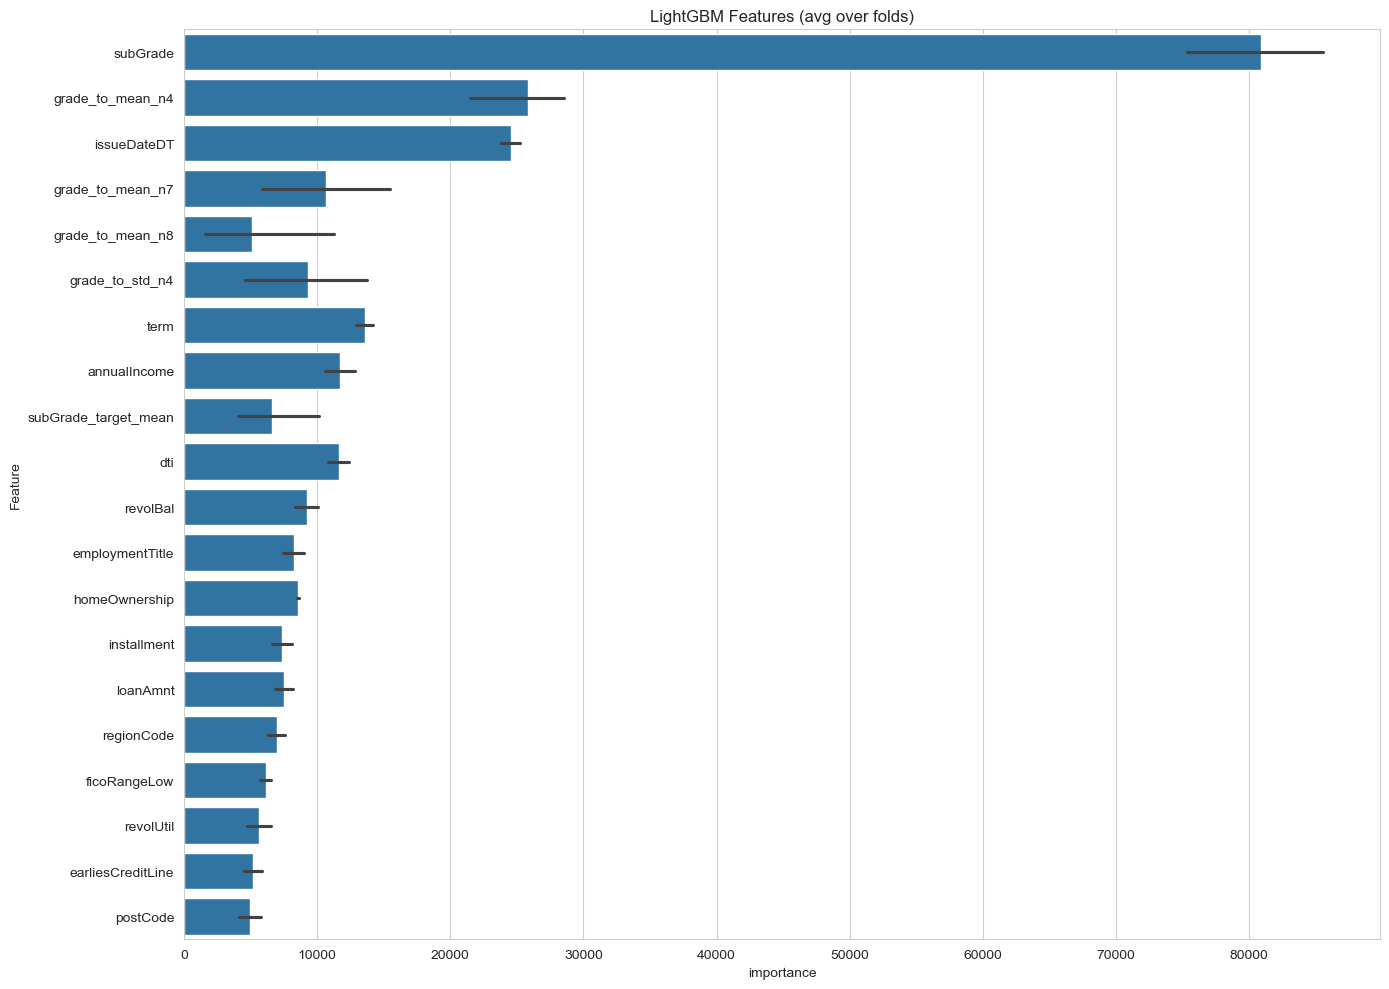

In [123]:
def plot_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:20].index)

    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(14, 10))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(feature_importance_df)

选择特征的方法
基于阈值筛选：
你可以设定一个特征重要性的阈值（例如，只保留重要性得分大于某个值的特征）。
基于排名筛选：
你可以选择前 N 个最重要的特征（例如，选择前 20 个特征）。
基于累积重要性筛选：
你可以计算特征重要性的累积贡献率，选择累积贡献率达到一定比例（例如，90%）的特征。


In [125]:
# 计算每个特征的平均重要性得分
mean_feature_importance = (feature_importance_df[["Feature", "importance"]]
                           .groupby("Feature")
                           .mean()
                           .sort_values(by="importance", ascending=False))

# 显示前30个最重要的特征
top_30_features = mean_feature_importance.head(30)
print(top_30_features)

                        importance
Feature                           
subGrade              80889.496983
grade_to_mean_n4      25801.699834
issueDateDT           24526.722871
term                  13624.295223
annualIncome          11673.733643
dti                   11654.621192
grade_to_mean_n7      10653.399197
grade_to_std_n4        9328.661741
revolBal               9210.618260
homeOwnership          8561.319081
employmentTitle        8249.154168
loanAmnt               7536.842753
installment            7374.363437
regionCode             6955.368591
subGrade_target_mean   6594.520348
ficoRangeLow           6133.493812
revolUtil              5638.362861
earliesCreditLine      5153.180718
grade_to_mean_n8       5084.496854
postCode               4928.623532
totalAcc               4430.741951
n2                     4172.232354
interestRate           4023.687574
n14                    3598.921870
grade_to_std_n6        2885.192515
grade_to_mean_n10      2872.269515
n6                  